# Actor-Critic in TensorFlow

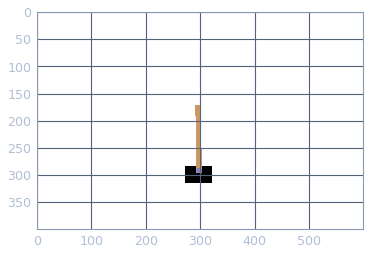

In [1]:
import gym
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, Flatten
from tensorflow.keras import Model
import matplotlib.pyplot as plt
%matplotlib inline

env = gym.make("CartPole-v0")


env.reset()
n_actions = env.action_space.n
state_dim = env.observation_space.shape

plt.imshow(env.render("rgb_array"))

In [3]:
class PolicyValueApproximator(Model):
    def __init__(self, action_dim):
        super().__init__()
        self.d1 = Dense(32, activation='relu', name='dense1')
        self.d2 = Dense(16, activation='relu', name='dense2')
        self.d3_policy = Dense(2, activation='relu', name='dense_policy')
        self.d3_value = Dense(1, activation='linear', name='dense_value')

    def __call__(self, x):
        x = self.d1(x)
        x = self.d2(x)
        policy = self.d3_policy(x)
        value = self.d3_value(x)
        return [value, policy]
        
    def model(self):
       # x = Input(shape=(4, ))
        x = Input(shape=(4,))
        return Model(inputs=x, outputs=self(x))

In [4]:
tf.keras.backend.clear_session()
policy_value_approximator = PolicyValueApproximator(action_dim=n_actions)

# Your code: define optimizers
optimizer = tf.keras.optimizers.Adam()
policy_value_approximator.model().summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 4)]          0                                            
__________________________________________________________________________________________________
dense1 (Dense)                  (None, 32)           160         input_1[0][0]                    
__________________________________________________________________________________________________
dense2 (Dense)                  (None, 16)           528         dense1[0][0]                     
__________________________________________________________________________________________________
dense_value (Dense)             (None, 1)            17          dense2[0][0]                     
______________________________________________________________________________________________

In [50]:
def policy(states):
    return tf.nn.softmax(policy_value_approximator(states)[1])

def log_policy(states):
    return tf.nn.log_softmax(policy_value_approximator(states)[1])

def get_action_probs(states):
    log_action_probs = tf.squeeze(log_policy(states), 0)
    action_probs = tf.squeeze(policy(states), 0)
    return log_action_probs, action_probs

def compute_entropy(action_probs, log_action_probs):
    return - tf.math.reduce_sum(tf.math.multiply(action_probs, log_action_probs))

def compute_policy_objective(log_action_probs, actions, rewards):
  #log_action_taken_probs = tf.gather_nd(log_action_probs, tf.stack([tf.range(log_action_probs.shape[0]), actions], axis=1))
    log_action_taken_probs = log_action_probs[a]
    J = tf.math.reduce_mean(tf.math.multiply(log_action_taken_probs, rewards))
    return J


In [104]:
def train_step(state_previous, state, action, reward, gamma=0.99, entropy_coef=1e-2):
    
    # Environment step
    
    # Gradient descent step  
    with tf.GradientTape(persistent=True) as tape:
        s_prev = tf.Variable(state_previous, dtype='float32', name='state_prev')
        s = tf.Variable(state, dtype='float32', name='state')
        a = tf.Variable(action, dtype='int32', name='action')
        r = tf.Variable(reward, dtype='float32', name='reward')
        
        # Get policy and value functions
        v_s, p_s = policy_value_approximator(s)
        
        # Get value function for the previous state
        v_s_prev = policy_value_approximator(s_prev)[0]
        
        # Compute action probs
        log_action_probs, action_probs = get_action_probs(s)
        
        # Compute entropy
        entropy = compute_entropy(log_action_probs, action_probs)
        
        # Compute policy objective
        J = compute_policy_objective(log_action_probs, a, r)
        policy_loss = -J - entropy_coef * entropy
        
        # Compute Bellman error
        delta = r + gamma * v_s - v_s_prev
        
        # Compute MSVE 
        MSVE = tf.math.square(delta)
    
    # Optimise the net and the policy output weights
    gradients_policy = tape.gradient(policy_loss, policy_value_approximator.trainable_variables[:6])
   # for i, gradient in enumerate(gradients_policy):
   #     gradients_policy[i] = delta * gamma * gradient
    optimizer.apply_gradients(zip(gradients_policy, policy_value_approximator.trainable_variables[:6]))      

    # Optimise the net and the policy output weights
    gradients_value = tape.gradient(MSVE, policy_value_approximator.trainable_variables[6:8])
   # for i, gradient in enumerate(gradients_value):
   #     gradients_value[i] = delta * gradient
    optimizer.apply_gradients(zip(gradients_value, policy_value_approximator.trainable_variables[6:8]))      



In [105]:
def generate_session(t_max=1000):
    
    # arrays to record session
    states, actions, rewards = np.asarray([], dtype='float32'), [], []

    s_prev = env.reset().astype('float32')
    
    for t in range(t_max):

        # action probabilities and log probabilities
        log_action_probs, action_probs = get_action_probs(np.reshape(s_prev, (1, 4)))
        log_action_probs = log_action_probs.numpy().reshape(2,)
        action_probs = action_probs.numpy().reshape(2,)
        # choose an action
        a = np.random.choice([0, 1], p=action_probs)
        # perform a step
        s, r, done, info = env.step(a)
        
        # perform a train step
        train_step(state_previous=np.reshape(s_prev, (1, 4)), state=np.reshape(s, (1, 4)), action=a, reward=r)
        
        # record session history to train later
        states = np.concatenate((states, s), axis=0)
        actions.append(a)
        rewards.append(r)

        s_prev = s.astype('float32')
        
        if done:
            break
            
    return states.reshape(-1, s.shape[0]), actions, rewards
    

In [106]:
tf.keras.backend.clear_session()
policy_value_approximator = PolicyValueApproximator(action_dim=n_actions)

# Your code: define optimizers
optimizer = tf.keras.optimizers.Adam()

In [110]:
global_rewards = []

for i in range(10000):

    _, _, rewards = generate_session() # generate new sessions
    global_rewards.append(rewards)
    
    if i % 100 == 0:
        print("Episode number {} and the reward is {}".format(i, np.mean(global_rewards[-100:])))
    
    if np.mean(global_rewards[-100:]) >= 300.0:
        print("You Win!")
        break

Episode number 0 and the reward is 1.0


TypeError: unsupported operand type(s) for /: 'list' and 'int'

In [27]:
policy_approximator.save_weights('model_weights/trained_policy_actor_critic')

In [28]:
# record sessions
import gym.wrappers
env = gym.wrappers.Monitor(gym.make("CartPole-v0"),
                           directory="videos_ac", force=True)
sessions = [generate_session() for _ in range(100)]
env.close()

In [30]:
# show video
from IPython.display import HTML
import os

video_names = list(
    filter(lambda s: s.endswith(".mp4"), os.listdir("./videos_ac/")))

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format("./videos/"+video_names[-1]))  # this may or may not be _last_ video. Try other indices